# Imports

In [11]:
import numpy as np
import pandas as pd

import copy
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import math
import datetime
import scipy as sp
import utm

# For a bigger output image
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

# Subsampling time-intervals:

In [12]:
def subsample_obs_time(df_in, time_interval_sec, obs_per_interval):

    obs = obs_per_interval
    time_inteval = time_interval_sec

    #Max and min time
    maxtime = max(df_in['datetimestamp'].values)
    mintime = min(df_in['datetimestamp'].values)

    #Total number of time sections in the data
    total_iter = int(maxtime/time_inteval) +1

    #start interval, inclusive
    lowerbound = mintime 
    #initial size, exclusive
    upperbound = time_inteval 

    #Result DATAFRAME
    df_sub_result = df_in.copy(deep = True)
    df_sub_result = df_sub_result.iloc[0:0] #drop all entries in the dataframe

    for subset_walk in np.arange(1,total_iter+2,1):#each subset present
        boolean_selection = ((lowerbound < df_in['datetimestamp']) & (df_in['datetimestamp'] <= upperbound)).values

        #subset for this interval
        time_subset = copy.deepcopy(df_in.iloc[boolean_selection,:])

        # subsampling the time sibset
        if obs < len(time_subset): #if the no of observations is lessthat the total in the timestep continue, else nothing
            for subsample in np.arange(0,len(time_subset), obs): #step with size = obs to sample each value in the set
                df_sub_result = df_sub_result.append(time_subset.iloc[subsample,:])

        #update bounds
        #start interval, inclusive
        lowerbound = copy.deepcopy(upperbound)
        upperbound = time_inteval*subset_walk

    return df_sub_result

## Other functions needed

In [13]:
def dataframe_stats (df_in):
    print("Length:",len(df_in['datetimestamp']))
    print("Total time:",max(df_in['datetimestamp']))
    print("Min Long:",min(df_in['long']))
    print("Max Long:",max(df_in['long']))
    print("Min lat:",min(df_in['lat']))
    print("Max lat:",max(df_in['lat']))

# Kalman - Conversions:

In [14]:
def convert_cog(data_in):
    return (data_in)*np.pi/180 #convert to radians

def convert_rot(data_in):
    return (data_in/60)*np.pi/180 #rad per second
    
def convert_sog(data_in):
    return data_in*0.5144444444 #meter per second

def convert_dataset(data_in, time_interval_sub, each_obs_sub):
    #Converting time date:
    df_sorted = copy.deepcopy(data_in.sort_values(by = 'datetimestamp', ascending = True ))
    #Getting the date of the first observation
    first_obs_date = df_sorted.iloc[0,6]

    #Subtracting the dates to get the seconds from start to finish
    df_sorted['datetimestamp'] = ((pd.to_datetime(df_sorted['datetimestamp']) - pd.to_datetime(first_obs_date)).dt.total_seconds())

    #Sub sample time interval in seconds, after dates has been converted to startin at 0 sec to 5000s (example)
    test = subsample_obs_time(df_sorted, time_interval_sub, each_obs_sub)
    df_sorted = copy.deepcopy(test)
    

    #Conversion of Course over ground
    df_sorted['cog'] = convert_cog(df_sorted['cog'])
    
    #Convert Speed over ground to mps
    df_sorted['sog'] = convert_sog(df_sorted['sog'])
    
    #Convert rate of turn 
    df_sorted['rot'] = convert_rot(df_sorted['rot'])
    
    #Making the order same as testset    
    df_sorted = df_sorted[['datetimestamp', 'lat', 'long', 'cog', 'sog','rot']]
    
    # Caluclating the the cartesian coordinates
    X = []
    Y = []
    
    #initial cartesian
    init_utm = utm.from_latlon(df_sorted['lat'].values[0], df_sorted['long'].values[0])
    X.append(init_utm[0])   #adding X coordinate
    Y.append(init_utm[1])   #Adding Y coordinate

    delta_time = [] #calculating delta time
    delta_time.append(0)
    for i in np.arange(1, len(df_sorted['datetimestamp']),1):
        delta_time.append(int(df_sorted['datetimestamp'].values[i]) - int(df_sorted['datetimestamp'].values[i-1]))
        #Caclulcating coordinates
        ans = utm.from_latlon(df_sorted['lat'].values[i], df_sorted['long'].values[i])
        #Adding the cartesian coordinates per time step
        X.append(copy.deepcopy(ans[0]))
        Y.append(copy.deepcopy(ans[1]))
    
   
    #Adding the delta time
    df_sorted.insert(1,'deltatime',delta_time) 
    #Adding cartesian coordiantes
    df_sorted['lat'] = Y
    df_sorted['long'] = X
   
    return df_sorted   

## Functions for the Kalman Filter

In [15]:
def get_mat_A(deltaTime):
    A = np.identity(4)
    A[0,2] = deltaTime
    A[1,3] = deltaTime
    return A

def predict_state(A, X_prev, a_x, a_y, deltaTIME):
        
    Bu_k = np.array([[a_x*deltaTIME*deltaTIME/2],
                     [a_y*deltaTIME*deltaTIME/2],
                     [a_x*deltaTIME],
                     [a_y*deltaTIME]])
    
    pred_state = A.dot(X_prev) + Bu_k
    return pred_state

def pred_err_cov(A, Pk, Q):
    return A.dot(Pk).dot(np.transpose(A)) + Q

def Kalman_gain(P_k, H, R):
    above = P_k.dot(np.transpose(H))
    bottom = np.linalg.inv(H.dot(P_k).dot(np.transpose(H)) + R)
    return above.dot(bottom)

def adjust_pred_state(pred_state, Kk,z_k,H):
    #Where z_k == the real observed value to adjust for the errors made
    return pred_state + Kk.dot(z_k - H.dot(pred_state))

def update_err_cov(I,Kk,H,P_k):
    return (I - Kk.dot(H)).dot(P_k)    

def calc_a_xy(arr_in, arr_prev):
    
    sog_now = np.around(arr_in[5],8)
    sog_prev = np.around(arr_prev[5],8)
    
    cog_now = np.around(arr_in[4],8)
    cog_prev = np.around(arr_prev[4],8)
    
    rot_now = np.around(arr_in[6],6)    
    delta_time = arr_in[1]   
    a_x = (sog_now*np.cos(cog_now + rot_now*delta_time) - sog_prev*np.cos(cog_prev))/delta_time    
    a_y = (sog_now*np.sin(cog_now + rot_now*delta_time) - sog_prev*np.sin(cog_prev))/delta_time 
    
    return a_x, a_y


def convert_state(arr_in):
    sog = arr_in[5]
    cog = arr_in[4]    
    x = arr_in[2]
    y = arr_in[3]        
    Vx = sog*np.cos(cog)
    Vy = sog*np.sin(cog)
    
    return_arr = np.array([[x],[y],[Vx],[Vy]])
    
    return return_arr

def extract_long_lat_covariance(mat_in):
    Var1 = mat_in[0,0]
    Var2 = mat_in[1,1]
    Cov12 = mat_in[0,1]
    
    result = np.array([[Var1,Cov12],[Cov12,Var2]])
    return result

def set_R(R_in, arr_x, arr_y, arr_Vx, arr_Vy):
    var_x = np.var(arr_x)
    var_y = np.var(arr_y)
    var_Vx = np.var(arr_Vx)
    var_Vy = np.var(arr_Vy)
    
    R_in[0,0] = var_x
    R_in[1,1] = var_y
    R_in[2,2] = var_Vx
    R_in[3,3] = var_Vy
    
    return R_in
    
    

In [16]:
test = np.arange(0,10)
test

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [17]:
k = 5
test[(k-5):k]

array([0, 1, 2, 3, 4])

# The Kalman Filter:

In [37]:
ax_arr = []
ay_arr= []
Pk_save_states = []
def myKalman(pd_final, R,Q,P_k,show_plots = True):
    global ax_arr, ay_arr, df_final,Pk_save_states
    
    H = np.identity(4)
    I = np.identity(4)   

    # Kalman Initial state
    X_state = np.array([[0],[0],[0],[0]])
    
    # Lists to append data and values to, saving ttansitions:
    ax_arr = []
    ay_arr = []
    X_save_states = []
    Pk_save_states = []
    Pk_save_states.append(copy.deepcopy(P_k))

    data_counter = 1 # counter for the original data set obsevations

    max_time = int(max(pd_final.iloc[:,0]))
    min_time = int(min(pd_final.iloc[:,0]))

    data_counter_stop = max_time-min_time
    
    R_temp = copy.deepcopy(R)
    
    x_arr = []
    y_arr = []
    Vx_arr = []
    Vy_arr = []
    
    realSpeedX = []
    realSpeedY = []
    realSpdCount = []
    for i in np.arange(0,max_time,1):
        
        
        if(i > 4):
            np.array(x_arr)
            
            R_temp = set_R(R_temp,
                           np.array(x_arr)[(i-5):i],
                           np.array(y_arr)[(i-5):i],
                           np.array(Vx_arr)[(i-5):i],
                           np.array(Vy_arr)[(i-5):i])
            
            R = copy.deepcopy(R)
            

        '''If we observe the value we observe this'''
        if(i == 0 or (int(pd_final.iloc[data_counter,0]) == i and data_counter < data_counter_stop)):
            zk_prev = pd_final.iloc[data_counter-1,:].values #previous observation
            z_k = pd_final.iloc[data_counter,:].values # convert to numpy array -observed value

            delta_TIME = copy.deepcopy(z_k[1]) #difference in time
            A = get_mat_A(delta_TIME)

            #Acceleration
            ax, ay = calc_a_xy(z_k,zk_prev) 
            ax_arr.append(ax)
            ay_arr.append(ay)

            z_k = copy.deepcopy(convert_state(z_k)) #convert state
            realSpdCount.append(i)
            realSpeedX.append(z_k[2][0])
            realSpeedY.append(z_k[3][0])
            X_state = copy.deepcopy(convert_state(zk_prev))

            #Kalman Predict--------------------------------------------------------------------------------------------
            X_state = copy.deepcopy(predict_state(A, X_state, ax, ay, delta_TIME))
            P_k =  copy.deepcopy(pred_err_cov(A, P_k, Q))

            #Kalman Measuremenet update--------------------------------------------------------------------------------
            Kalman_k = copy.deepcopy(Kalman_gain(P_k, H, R))
            X_state = copy.deepcopy(adjust_pred_state(X_state, Kalman_k, z_k, H))
            P_k = copy.deepcopy(update_err_cov(I, Kalman_k, H, P_k))


            #increment counter
            data_counter += 1

            #Saving states
            X_save_states.append(copy.deepcopy(X_state))
            Pk_save_states.append(copy.deepcopy(P_k))

        else:
            '''This code will be excecuted when we have no observation'''
            ay = 0
            ax = 0
            A = get_mat_A(1)
            #Kalman Predict --------------------------------------------------------------------------
            X_state = copy.deepcopy(predict_state(A, X_state, ax, ay, 1))
            P_k =  copy.deepcopy(pred_err_cov(A,P_k,Q))

            #Saving states
            Pk_save_states.append(copy.deepcopy(P_k))
            X_save_states.append(copy.deepcopy(X_state))
            
        x_arr.append(copy.deepcopy(X_state[0][0]))
        y_arr.append(copy.deepcopy(X_state[1][0]))
        Vx_arr.append(copy.deepcopy(X_state[2][0]))
        Vy_arr.append(copy.deepcopy(X_state[3][0]))



    # Saving the coordinates:
    X_coord = []
    Y_coord = []
    Pk_coord  = []
    SpeedX = []
    SpeedY = []
    
    
    

    for i in range(0,len(X_save_states)):
        if i > 1 and  i % 1 == 0:
            X_coord.append(X_save_states[i][0][0])
            Y_coord.append(X_save_states[i][1][0])
            SpeedX.append(X_save_states[i][2][0]) #Speed in X axis
            SpeedY.append(X_save_states[i][3][0]) #Speed in Y axis
            
            #Pk_coord.append(extract_long_lat_covariance(Pk_save_states[i]))

    #Extracting the original data:
    X_orig = copy.deepcopy(pd_final.iloc[:,2])
    Y_orig = copy.deepcopy(pd_final.iloc[:,3])

    
    if(show_plots):
        #Graph outputs:
        '''Speed in the X-axis'''
        plt.plot(np.arange(0,len(SpeedX),1), SpeedX, 'b-')
        plt.plot(realSpdCount, realSpeedX,'r-')
        plt.title("Linear Speed in X")
        legend_data = ["Kalman","Original" ]
        plt.legend(legend_data,loc = 'best')
        plt.show()

        '''Speed in the Y-axis'''
        plt.plot(np.arange(0,len(SpeedY),1),SpeedY)
        plt.plot(realSpdCount, realSpeedY,'r-')
        legend_data = ["Kalman","Original" ]
        plt.legend(legend_data,loc = 'best')
        plt.title("Linear Speed in Y")    
        plt.show()

        '''X coordinate tracking'''
        plt.plot(realSpdCount,Y_orig[0:(len(realSpdCount))], "bo")
        plt.plot(np.arange(0,len(Y_coord),1),Y_coord, "r.")
        legend_data = ["Original","Kalman"]
        plt.legend(legend_data,loc = 'best')
        plt.title("X pred (red) vs original (blue)")
        plt.show()

        '''Y coordinate tracking'''
        plt.plot(realSpdCount,X_orig[0:(len(realSpdCount))], "bo")
        plt.plot(np.arange(0,len(X_coord),1),X_coord, "r.")
        plt.title("Y pred (red) vs original (blue)")
        legend_data = ["Original","Kalman"]
        plt.legend(legend_data,loc = 'best')
        plt.show()

    
    return np.array(X_coord),np.array(Y_coord),X_orig,Y_orig,ax_arr,ay_arr, SpeedX, SpeedY, np.array(realSpdCount)


# Importing dataset & getting linear trajectory:

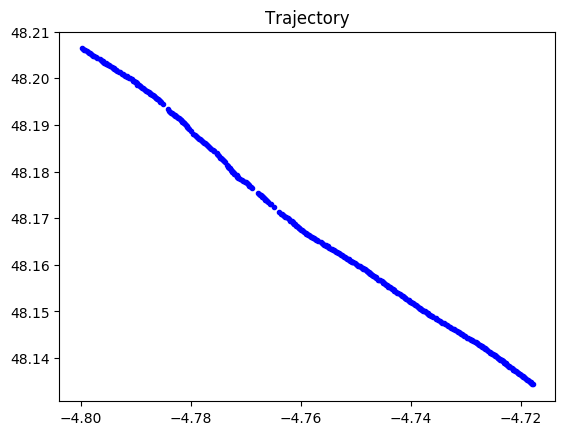

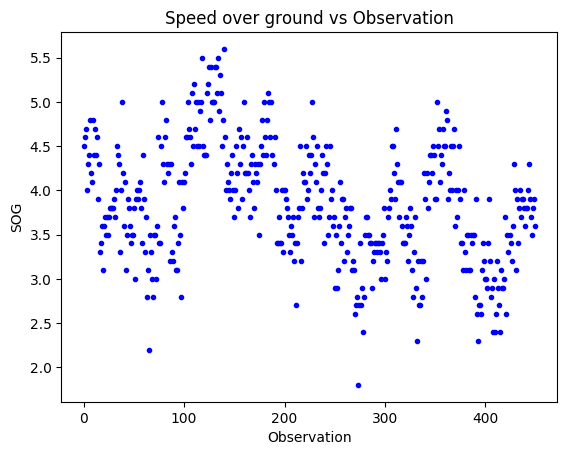

In [38]:
pd_dataset = None 
pd_dataset = pd.read_csv(r"577228000.csv")

#Boundaries sampling from and to
lower = 300
upper = 750

plt.plot(pd_dataset['long'].values[lower:upper],pd_dataset['lat'].values[lower:upper],'b.')
plt.title("Trajectory")
plt.show()

plt.plot(np.arange(0,len(pd_dataset['sog'].values[lower:upper]),1),pd_dataset['sog'].values[lower:upper],'b.')
plt.title("Speed over ground vs Observation")
plt.xlabel("Observation")
plt.ylabel("SOG")
plt.show()

# SUB SAMPLING & TRAJECTORY EXTRACTION

In [39]:
lower = 420
upper = 850
myrange = np.arange(lower,upper,1) #to cut the part thats goint to be used

pd_dataset_new = convert_dataset(pd_dataset.iloc[myrange,:].reset_index(drop = True),240,1)
#The pandas dataframe index needs to be resetted so that the indexing does'nt play a factor

### Trajectory statistics:

In [40]:
#Getting some stats on the extracted trajectory
dataframe_stats(pd_dataset_new)    

Length: 429
Total time: 4970.0
Min Long: 367922.5362110208
Max Long: 373981.8763136473
Min lat: 5331295.505486576
Max lat: 5338462.639838013


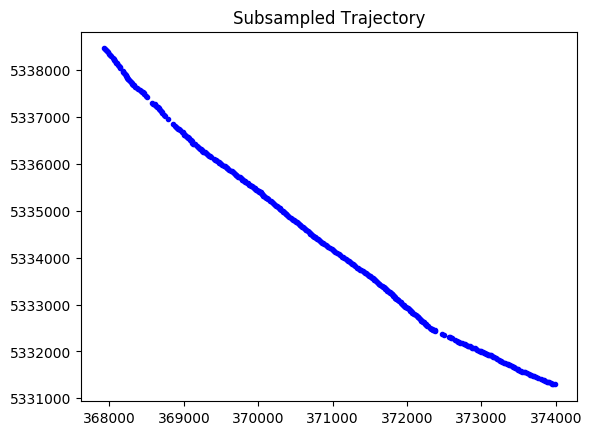

In [41]:
#Deepcopy the new dataset to the sampled one
df_sampled = copy.deepcopy(pd_dataset_new)

plt.plot(df_sampled['long'],df_sampled['lat'],'b.')
plt.title("Subsampled Trajectory")
plt.show()

# Setting up $P_k$

In [42]:
#IMO Standards
var_X = 10
var_Y = 10
var_spdX = 0.3
var_spdY = 0.3

P_k = np.array([[var_X],[var_Y],[var_spdX],[var_spdY]]).dot(np.transpose(
      np.array([[var_X],[var_Y],[var_spdX],[var_spdY]])))

# Setting up $Q$:



In [43]:
# IMO standards:
var_X = 10
var_Y = 10
var_spdX = 0.3
var_spdY = 0.3

Q = np.array([[var_X],[var_Y],[var_spdX],[var_spdY]]).dot(np.transpose(
      np.array([[var_X],[var_Y],[var_spdX],[var_spdY]]))) 

# Setting up R:


In [44]:
R = np.diag(np.diag(P_k))

# Running the Kalman filter

In [45]:
X_samp_pred, Y_samp_pred, X_samp_orig, Y_samp_orig, _, _, _,_, Kalman_observed_sec = myKalman(df_sampled, R,Q,P_k,False)

# Linear Implementation

### This will be a function of time
We will be estimating X Y SpeedOverGround CourseOverGround. With this we can calculate the speed in the X and Y axis respectively.

#### Idea:
$X_{new} =  X_{old} + Speed_{x-axis} \times time$

$Y_{new} =  Y_{old} + Speed_{y-axis} \times time$


# Import the linear regression model from Scikit learn

In [46]:
import numpy as np
from sklearn.linear_model import LinearRegression

In [47]:
def AIS_linear(df_in, lin_remember_history, show_plots = True):
    '''
        df_in:  Pandas Data Frame,
                AIS data frame with more or less linear trajectory
        lin_remember_history: integer,  (default = 5)
                This integer value should specify the number of historical observations the linear method 
                are based on
    '''
    #REMEMBER HISTORY OF MODEL
    remember_history = lin_remember_history 
    
    # Extracting the values from the dataframe
    X_have = df_in['long'].values
    Y_have = df_in['lat'].values
    time = df_in['datetimestamp'].values.astype(int) #exctracting time as an array
    #Extracting speed
    speed = df_in['sog'].values
    course = df_in['cog'].values
      
    #Intitial parameters
    current_course = course[0] #initial course value. It remains constant only update if a new value comes
    
    #Time range in seconds
    sec_range = np.arange(0,int(max(time))+1,1)
    
    sec_observed = [] # to rememember when a second was an observed second

    
    #To save historical times
    time_history = np.array([]) # thislist will keep track of the last times recorded, intitial time == 0
    speed_history = np.array([]) # this list keep track of the speeds recorded
    pred_speed = np.array([]) # this list stores the predicted values

    #Speed in X Y
    pred_speedX =  []
    pred_speedY = []
    orig_speedX = []
    orig_speedY = []

    #Saving prediction
    speed_pred = []

    # Saving the X and Y predictions
    X_loc_pred = []
    Y_loc_pred = []
    
    # Setting initial values
    X_new =  X_have[0]
    Y_new = Y_have[0]
    X_error = 0
    Y_error = 0


    #Initial Regression guess with a speed of 4.8, just a random speed value nothing special about it
    reg = LinearRegression()
    reg.fit(np.array([0]).reshape(-1,1),np.array([4.8]).reshape(-1,1))

    #counting the entries to appropriatly measure difference
    counter_sec = 0 
    for sec in sec_range:    
        '''IF WE OBSERVE the value'''

        if(time[counter_sec] == sec):
            sec_observed.append(sec) #We observed index at this second

            if len(time_history) > remember_history : #if the list is long enough
                speed_history = np.delete(speed_history,0) #remove 1st entry in array
                time_history = np.delete(time_history,0) # remove 1st entry in array

            #Saving the last moments up to specified history amount    
            time_history = np.append(time_history,sec)
            speed_history = np.append(speed_history,speed[counter_sec])
            current_course =  course[counter_sec]

            #Fit a new model
            reg = LinearRegression()
            reg.fit(time_history.reshape(-1,1),speed_history.reshape(-1,1))

            #PREDICTING SPEED
            predict_speed_value = reg.predict(np.array([sec]).reshape(-1,1))
            pred_speed = np.append(pred_speed,predict_speed_value)

            #SPEED IN X AN Y AXIS
            pred_X_axis_speed = predict_speed_value[0][0]*np.cos(current_course)
            pred_speedX.append(pred_X_axis_speed)   
            pred_Y_axis_speed = predict_speed_value[0][0]*np.sin(current_course)
            pred_speedY.append(pred_Y_axis_speed)

            # SAVING ORIGINAL VALUES
            orig_speedX.append(speed[counter_sec]*np.cos(course[counter_sec]))
            orig_speedY.append(speed[counter_sec]*np.sin(course[counter_sec]))

            #PREDICTING MOVEMENT IN X AND Y
            X_new = X_new + pred_X_axis_speed
            X_error = X_have[counter_sec] - X_new  # to update next position to the correct spot c
            X_loc_pred.append(X_new)

            Y_new = Y_new + pred_Y_axis_speed
            Y_error = Y_have[counter_sec] - Y_new  # to update next position to the correct spot c
            Y_loc_pred.append(Y_new)

            #Counter to walk through list
            counter_sec += 1   
        else:
            #JUST PERDICT
            predict_speed_value = reg.predict(np.array([sec]).reshape(-1,1))
            #SPEED
            pred_speed = np.append(pred_speed, predict_speed_value)
            #SPEED IN X AN Y AXIS 
            pred_X_axis_speed = predict_speed_value[0][0]*np.cos(current_course)
            pred_speedX.append(pred_X_axis_speed)   
            pred_Y_axis_speed = predict_speed_value[0][0]*np.sin(current_course)
            pred_speedY.append(pred_Y_axis_speed)

            #PREDICTING MOVEMENT IN X AND Y
            X_new = X_new + pred_X_axis_speed + X_error
            X_error = 0 #reset the error after the correction

            Y_new = Y_new + pred_Y_axis_speed + Y_error
            Y_error = 0 #reset the error after the correction
            
            Y_loc_pred.append(Y_new)
            X_loc_pred.append(X_new)


    
    if(show_plots):
        # PLOTTING - Functions
        plt.plot(sec_range,pred_speed,'r-')
        plt.plot(time,speed,"b-")
        legend_data = ["Linear Method", "Original Data"]
        plt.legend(legend_data,loc = 'best')
        plt.title("Linear method tracking speed")
        plt.ylabel("SOG")
        plt.xlabel("Time")
        plt.show()

        #print(pred_speedX)
        plt.plot(sec_range,np.array(pred_speedX),'r-')
        plt.plot(time,np.array(orig_speedX),'b-')
        legend_data = ["Linear Method", "Original Data"]
        plt.legend(legend_data,loc = 'best')
        plt.title("Speed in X-axis tracking")
        plt.ylabel("SOG")
        plt.xlabel("Time")
        plt.show()


        plt.plot(sec_range,np.array(pred_speedY),'r-')
        plt.plot(time,np.array(orig_speedY),'b-')
        legend_data = ["Linear Method", "Original Data"]
        plt.legend(legend_data,loc = 'best')
        plt.title("Speed in Y-axis tracking")
        plt.ylabel("SOG")
        plt.xlabel("Time")
        plt.show()

        plt.plot(sec_range,np.array(X_loc_pred),'b-')
        plt.plot(time,X_have,'r-')
        legend_data = ["Linear Method", "Original Data"]
        plt.legend(legend_data,loc = 'best')
        plt.title("Y-axis tracking")
        plt.ylabel("SOG")
        plt.xlabel("Time")
        plt.show()

        plt.plot(sec_range,np.array(Y_loc_pred),'b-')
        plt.plot(time,Y_have,'r-')
        legend_data = ["Linear Method", "Original Data"]
        plt.legend(legend_data,loc = 'best')
        plt.title("X-axis tracking")
        plt.ylabel("SOG")
        plt.xlabel("Time")
        plt.show()

        plt.plot(Y_have, X_have,'bx')
        plt.plot(Y_loc_pred,X_loc_pred,'r-')
        legend_data = ["Original Data","Linear Method" ]
        plt.legend(legend_data,loc = 'best')
        plt.title("FINAL RESULT - LINEAR")
        plt.ylabel("SOG")
        plt.xlabel("Time")
        plt.show()   

    return np.array(X_loc_pred), np.array(Y_loc_pred), np.array(pred_speed), np.array(sec_observed)

In [48]:
pred_linear_X, pred_linear_Y,pred_linear_SOG, linear_sec_ob = AIS_linear(df_mmsi,5,False)

NameError: name 'df_mmsi' is not defined

In [49]:
def calculate_errors(df_orig,df_sub, pred_X, pred_Y, observed_sec, show_plots = False):
    time_steps = df_orig['datetimestamp'].values.astype(int)   
    
    max_time = max(observed_sec)
    time_steps = time_steps[time_steps <= max_time] 
    
    
    X_pred_orig = pred_X[time_steps]
    Y_pred_orig = pred_Y[time_steps]  
    
    test = np.arange(0,len(X_pred_orig),1)
    

    X_orig = df_orig['long'].values[test]  
    Y_orig = df_orig['lat'].values [test] 
    

    
    X_MSE = np.sum((X_orig - X_pred_orig )**2)/len(test)
    Y_MSE = np.sum((Y_orig - Y_pred_orig )**2)/len(test)
    
    Euclid_AVG = np.sum(np.sqrt((X_orig - X_pred_orig)**2 + (Y_orig - Y_pred_orig )**2))/len(X_pred_orig)
    
    
    X_error = X_orig - X_pred_orig
    Y_error = Y_orig - Y_pred_orig 
    Euclid_err = np.sqrt((X_orig - X_pred_orig)**2 + (Y_orig - Y_pred_orig )**2)
    
    if(show_plots):
        plt.plot(time_steps,X_error,'.')
        plt.plot(time_steps,Y_error,'.')
        plt.plot(time_steps,Euclid_err,'.')
        plt.title("Long Lat and total distance error")
        plt.xlabel("Time")
        plt.ylabel("Metres")
        legend_lab = ["X-error","Y-error","Euclidean"]
        plt.legend(legend_lab, loc = "best")
        plt.show()
    
    
        print("X_MSE",X_MSE)
        print("Y_MSE",Y_MSE)
        print("Euclid_AVG",Euclid_AVG) 
    
    return X_MSE, Y_MSE, Euclid_AVG

In [50]:
pred_linear_X, pred_linear_Y,pred_linear_SOG,linear_sec_ob = AIS_linear(df_subMMSI,2)

print(len(pred_linear_X))
print(len(pred_linear_Y))
print(len(pred_linear_SOG))
print(len(linear_sec_ob))

NameError: name 'df_subMMSI' is not defined

## Dataset

In [51]:
pd_dataset = None 
pd_dataset = pd.read_csv(r"304519000.csv")
lower = 300
upper = 750
myrange = np.arange(lower,upper,1) #to cut the part thats goint to be used
df_origMMSI = convert_dataset(pd_dataset.iloc[myrange,:].reset_index(drop = True),240,1)

In [52]:
df_mmsi_and_range = pd.DataFrame(columns=['MMSI','START', 'END'])

arr_MMSI = np.array(['538004506.csv',
                       '226105000.csv',
                       '235097013.csv',
                       '305714000.csv',
                       '304519000.csv',
                       '304927000.csv',
                       '636092331.csv',
                       '224389000.csv',
                       '220540000.csv',
                       '211286440.csv',
                       '207138000.csv',
                       '207138000.csv',
                       '215901000.csv',
                       '227146400.csv',
                       '314237000.csv',
                       '565494000.csv',
                       '244740921.csv',
                       '227330000.csv',
                       '227372000.csv',
                       '228130000.csv',
                       '228727000.csv',
                       '227988000.csv',
                       '244925000.csv',
                       '247224200.csv',
                       '249104000.csv',
                       '518866000.csv',
                       '276700000.csv',
                       '577228000.csv',
                       '227558000.csv','227364000.csv'])

MMSI_starts = np.array([10 ,420,200,5  ,300,300,4358,128,120,2210,150,790 ,50 ,960 ,1000,20 ,5200,
               50 ,10 ,20 ,100,1600,0  ,210,200,350,300,300,350,495])
MMSI_ends   = np.array([350,850,400,600,750,750,4850,375,560,2800,590,1200,600,1500,1500,550,5600,
               550,420,450,500,2000,450,620,650,800,700,750,800,850])


# Kalman Filter & Linear Funcition

In [53]:
my_sequence = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21])
df_results = pd.DataFrame(columns=['MMSI',
                                   'Method', 
                                   'Sub1',
                                    'Sub2',
                                    'Sub3',
                                    'Sub4',
                                    'Sub5',
                                    'Sub6',
                                    'Sub7',
                                    'Sub8',
                                    'Sub9',
                                    'Sub10',
                                    'Sub11',
                                    'Sub12',
                                    'Sub13',
                                    'Sub14',
                                    'Sub15',
                                    'Sub16',
                                    'Sub17',
                                    'Sub18',
                                    'Sub19',
                                    'Sub20',
                                    'Sub21'])
    
for data_set in range(0,30):
    my_MMSI = arr_MMSI[data_set]
    start = MMSI_starts[data_set] 
    end = MMSI_ends[data_set] 
    
    print("\n\n\nMMSI NO:",my_MMSI,"START:", start, "END:", end)
    
    pd_dataset = pd.read_csv(my_MMSI)
    lower = start
    upper = end
    myrange = np.arange(lower,upper,1) #to cut the part thats goint to be used
    df_origMMSI = convert_dataset(pd_dataset.iloc[myrange,:].reset_index(drop = True),240,1)


    Kalman_error_EuclidXY =   []
    Linear_error_EuclidYX =   []
    
    for sub_sample_data in my_sequence:
        #print("\n\n\n\n\n\nSUB SAMPLE SIZE: ",sub_sample_data )
        df_subMMSI = convert_dataset(pd_dataset.iloc[myrange,:].reset_index(drop = True),240,sub_sample_data)

        Kalman_X_pred, Kalman_Y_pred, X_samp_orig, Y_samp_orig, _, _, _,_,Kalman_observed_sec = myKalman(df_subMMSI, R,Q,P_k, False)
        #print('------------------------------------- LINEAR METHOD ---------------------------------------')
        pred_linear_X, pred_linear_Y,pred_linear_SOG,linear_sec_ob = AIS_linear(df_subMMSI,5,False)

        #print('------------------------------------- KALMAN ERROR ---------------------------------------')
        Kalman_X_MSE, Kalman_Y_MSE, Kalman_Euclid_AVG = calculate_errors(df_origMMSI,df_subMMSI,Kalman_Y_pred,Kalman_X_pred,Kalman_observed_sec, False)
        #print('------------------------------------- LINEAR ERROR ---------------------------------------')
        Linear_X_MSE, Linear_Y_MSE, Linear_Euclid_AVG = calculate_errors(df_origMMSI,df_subMMSI,pred_linear_X,pred_linear_Y,linear_sec_ob, False)

        #APPENDINGS

        Kalman_error_EuclidXY.append(Kalman_Euclid_AVG)
        Linear_error_EuclidYX.append(Linear_Euclid_AVG)
        
    Kalman_error_EuclidXY = np.array(Kalman_error_EuclidXY)
    Linear_error_EuclidYX = np.array(Linear_error_EuclidYX)
 
    df_results = df_results.append({'MMSI': my_MMSI,'Method': 'Kalman', 
                                   'Sub1':Kalman_error_EuclidXY[0],
                                    'Sub2':Kalman_error_EuclidXY[1],
                                    'Sub3':Kalman_error_EuclidXY[2],
                                    'Sub4':Kalman_error_EuclidXY[3],
                                    'Sub5':Kalman_error_EuclidXY[4],
                                    'Sub6':Kalman_error_EuclidXY[5],
                                    'Sub7':Kalman_error_EuclidXY[6],
                                    'Sub8':Kalman_error_EuclidXY[7],
                                    'Sub9':Kalman_error_EuclidXY[8],
                                    'Sub10':Kalman_error_EuclidXY[9],
                                    'Sub11':Kalman_error_EuclidXY[10],
                                    'Sub12':Kalman_error_EuclidXY[11],
                                    'Sub13':Kalman_error_EuclidXY[12],
                                    'Sub14':Kalman_error_EuclidXY[13],
                                    'Sub15':Kalman_error_EuclidXY[14],
                                    'Sub16':Kalman_error_EuclidXY[15],
                                    'Sub17':Kalman_error_EuclidXY[16],
                                    'Sub18':Kalman_error_EuclidXY[17],
                                    'Sub19':Kalman_error_EuclidXY[18],
                                    'Sub20':Kalman_error_EuclidXY[19],
                                    'Sub21':Kalman_error_EuclidXY[20]}, ignore_index=True)
    

    df_results = df_results.append({'MMSI': my_MMSI,'Method': 'Linear', 
                                   'Sub1':Linear_error_EuclidYX[0],
                                    'Sub2':Linear_error_EuclidYX[1],
                                    'Sub3':Linear_error_EuclidYX[2],
                                    'Sub4':Linear_error_EuclidYX[3],
                                    'Sub5':Linear_error_EuclidYX[4],
                                    'Sub6':Linear_error_EuclidYX[5],
                                    'Sub7':Linear_error_EuclidYX[6],
                                    'Sub8':Linear_error_EuclidYX[7],
                                    'Sub9':Linear_error_EuclidYX[8],
                                    'Sub10':Linear_error_EuclidYX[9],
                                    'Sub11':Linear_error_EuclidYX[10],
                                    'Sub12':Linear_error_EuclidYX[11],
                                    'Sub13':Linear_error_EuclidYX[12],
                                    'Sub14':Linear_error_EuclidYX[13],
                                    'Sub15':Linear_error_EuclidYX[14],
                                    'Sub16':Linear_error_EuclidYX[15],
                                    'Sub17':Linear_error_EuclidYX[16],
                                    'Sub18':Linear_error_EuclidYX[17],
                                    'Sub19':Linear_error_EuclidYX[18],
                                    'Sub20':Linear_error_EuclidYX[19],
                                    'Sub21':Linear_error_EuclidYX[20],}, ignore_index=True)

df_results.to_csv(r"KalmanVSlinearResults.csv", index = False, header=True)




MMSI NO: 538004506.csv START: 10 END: 350



MMSI NO: 226105000.csv START: 420 END: 850



MMSI NO: 235097013.csv START: 200 END: 400


KeyboardInterrupt: 

In [119]:
# print('Kalman')
# print(len(Kalman_X_pred))
# print(len(Kalman_Y_pred))
# print("-")
# print(Kalman_observed_sec)

# print('Linear')
# print(pred_linear_X)
# print(pred_linear_Y)
# print(pred_linear_SOG)
# print(linear_sec_ob)

In [136]:
df_results

,MMSI,Method,Sub1,Sub2,Sub3,Sub4,Sub5,Sub6,Sub7,Sub8,...,Sub12,Sub13,Sub14,Sub15,Sub16,Sub17,Sub18,Sub19,Sub20,Sub21
0,538004506.csv,Kalman,11.147618,14.043763,18.280021,22.349622,26.392917,41.978844,48.552513,52.166449,...,66.035772,219.267423,238.890703,241.506854,246.747698,568.236519,570.651099,588.334360,597.866136,1733.047505
1,538004506.csv,Linear,34.058362,49.829574,65.798413,81.674596,97.618461,112.568725,124.323407,140.100582,...,204.320314,241.079796,254.634732,266.061557,279.796688,446.979374,463.232449,480.577076,515.402227,1256.648764
2,226105000.csv,Kalman,18.614429,30.205486,63.560837,151.891292,223.375860,279.196644,394.408326,474.493519,...,500.557659,540.670225,513.454141,481.242048,494.815547,464.820342,918.892315,864.048060,838.706009,1462.621459
3,226105000.csv,Linear,131.862139,196.870995,259.037548,320.621001,383.930610,442.962542,506.068137,571.729379,...,775.008365,808.430173,853.570961,905.231706,945.554557,1033.746736,1125.093144,1223.129696,1625.987556,2058.121446
4,235097013.csv,Kalman,10.626722,13.843172,19.353741,24.014264,45.352574,97.239776,57.285038,131.058387,...,177.028373,157.077378,171.770242,187.836761,166.177901,162.014015,162.113080,153.483046,135.477287,133.528528
5,235097013.csv,Linear,75.625890,112.261964,148.458713,186.403811,218.694641,260.427063,284.989564,332.380579,...,474.635153,487.802470,499.286748,516.678167,540.285794,571.128217,606.929332,648.764354,694.490947,746.665411
6,305714000.csv,Kalman,7.822227,27.182771,39.151749,86.494289,124.872921,161.752834,192.013643,183.238259,...,416.811762,295.164050,424.971538,950.429327,594.177428,1774.187039,1171.467330,1494.309731,2223.086484,3640.662151
7,305714000.csv,Linear,73.339518,117.968491,154.043052,214.533520,274.847020,305.208879,324.365351,363.785636,...,734.917217,698.567073,729.512014,1063.075797,1255.690170,2235.447056,2267.360017,2270.229385,6959.816840,6961.939719
8,304519000.csv,Kalman,14.150929,25.105802,43.767632,64.895586,65.653514,101.126517,95.969471,127.864992,...,208.509701,261.347135,239.369830,239.216257,189.981171,168.560275,173.521517,207.527093,243.996282,215.826164
9,304519000.csv,Linear,53.194535,78.974595,104.261485,130.122084,153.186323,179.779981,196.565699,232.699876,...,335.135082,339.504851,349.761928,361.099392,377.785637,397.002795,420.781869,449.688002,483.794404,519.465913


In [137]:
df_results.to_csv(r"KalmanVSlinearResults_1_21.csv", index = False, header=True)

In [138]:
my_stats = pd.read_csv(r"KalmanVSlinearResults_1_21.csv")

In [139]:
Kalman_stats = my_stats.iloc[np.arange(0,60,2),:]
Linear_stats = my_stats.iloc[np.arange(1,60,2),:]

In [140]:
Kalman_stats.head()

,MMSI,Method,Sub1,Sub2,Sub3,Sub4,Sub5,Sub6,Sub7,Sub8,...,Sub12,Sub13,Sub14,Sub15,Sub16,Sub17,Sub18,Sub19,Sub20,Sub21
0,538004506.csv,Kalman,11.147618,14.043763,18.280021,22.349622,26.392917,41.978844,48.552513,52.166449,...,66.035772,219.267423,238.890703,241.506854,246.747698,568.236519,570.651099,588.334360,597.866136,1733.047505
2,226105000.csv,Kalman,18.614429,30.205486,63.560837,151.891292,223.375860,279.196644,394.408326,474.493519,...,500.557659,540.670225,513.454141,481.242048,494.815547,464.820342,918.892315,864.048060,838.706009,1462.621459
4,235097013.csv,Kalman,10.626722,13.843172,19.353741,24.014264,45.352574,97.239776,57.285038,131.058387,...,177.028373,157.077378,171.770242,187.836761,166.177901,162.014015,162.113080,153.483046,135.477287,133.528528
6,305714000.csv,Kalman,7.822227,27.182771,39.151749,86.494289,124.872921,161.752834,192.013643,183.238259,...,416.811762,295.164050,424.971538,950.429327,594.177428,1774.187039,1171.467330,1494.309731,2223.086484,3640.662151
8,304519000.csv,Kalman,14.150929,25.105802,43.767632,64.895586,65.653514,101.126517,95.969471,127.864992,...,208.509701,261.347135,239.369830,239.216257,189.981171,168.560275,173.521517,207.527093,243.996282,215.826164


In [141]:
Linear_stats.head()

,MMSI,Method,Sub1,Sub2,Sub3,Sub4,Sub5,Sub6,Sub7,Sub8,...,Sub12,Sub13,Sub14,Sub15,Sub16,Sub17,Sub18,Sub19,Sub20,Sub21
1,538004506.csv,Linear,34.058362,49.829574,65.798413,81.674596,97.618461,112.568725,124.323407,140.100582,...,204.320314,241.079796,254.634732,266.061557,279.796688,446.979374,463.232449,480.577076,515.402227,1256.648764
3,226105000.csv,Linear,131.862139,196.870995,259.037548,320.621001,383.930610,442.962542,506.068137,571.729379,...,775.008365,808.430173,853.570961,905.231706,945.554557,1033.746736,1125.093144,1223.129696,1625.987556,2058.121446
5,235097013.csv,Linear,75.625890,112.261964,148.458713,186.403811,218.694641,260.427063,284.989564,332.380579,...,474.635153,487.802470,499.286748,516.678167,540.285794,571.128217,606.929332,648.764354,694.490947,746.665411
7,305714000.csv,Linear,73.339518,117.968491,154.043052,214.533520,274.847020,305.208879,324.365351,363.785636,...,734.917217,698.567073,729.512014,1063.075797,1255.690170,2235.447056,2267.360017,2270.229385,6959.816840,6961.939719
9,304519000.csv,Linear,53.194535,78.974595,104.261485,130.122084,153.186323,179.779981,196.565699,232.699876,...,335.135082,339.504851,349.761928,361.099392,377.785637,397.002795,420.781869,449.688002,483.794404,519.465913


In [142]:
Kal_sub1 = np.average(Kalman_stats['Sub1'])
Kal_sub2 = np.average(Kalman_stats['Sub2'])
Kal_sub3 = np.average(Kalman_stats['Sub3'])
Kal_sub4 = np.average(Kalman_stats['Sub4'])
Kal_sub5 = np.average(Kalman_stats['Sub5'])
Kal_sub6 = np.average(Kalman_stats['Sub6'])
Kal_sub7 = np.average(Kalman_stats['Sub7'])
Kal_sub8 = np.average(Kalman_stats['Sub8'])
Kal_sub9 = np.average(Kalman_stats['Sub9'])
Kal_sub10 = np.average(Kalman_stats['Sub10'])
Kal_sub11 = np.average(Kalman_stats['Sub11'])
Kal_sub12 = np.average(Kalman_stats['Sub12'])
Kal_sub13 = np.average(Kalman_stats['Sub13'])
Kal_sub14 = np.average(Kalman_stats['Sub14'])
Kal_sub15 = np.average(Kalman_stats['Sub15'])
Kal_sub16 = np.average(Kalman_stats['Sub16'])
Kal_sub17 = np.average(Kalman_stats['Sub17'])
Kal_sub18 = np.average(Kalman_stats['Sub18'])
Kal_sub19 = np.average(Kalman_stats['Sub19'])
Kal_sub20 = np.average(Kalman_stats['Sub20'])
Kal_sub21 = np.average(Kalman_stats['Sub21'])


Kalman_errors = np.array([Kal_sub1,
                 Kal_sub2,
                 Kal_sub3,
                 Kal_sub4,
                 Kal_sub5,
                 Kal_sub6,
                 Kal_sub7,
                 Kal_sub8,
                 Kal_sub9,                 
                 Kal_sub10,
                 Kal_sub11,
                 Kal_sub12,
                 Kal_sub13,
                 Kal_sub14,
                 Kal_sub15,
                 Kal_sub16,
                 Kal_sub17,
                 Kal_sub18,
                 Kal_sub19,
                 Kal_sub20,
                 Kal_sub21])

Kalman_errors_STDs= np.array([
                    np.std(Kalman_stats['Sub1']),
                    np.std(Kalman_stats['Sub2']),
                    np.std(Kalman_stats['Sub3']),
                    np.std(Kalman_stats['Sub4']),
                    np.std(Kalman_stats['Sub5']),
                    np.std(Kalman_stats['Sub6']),
                    np.std(Kalman_stats['Sub7']),
                    np.std(Kalman_stats['Sub8']),
                    np.std(Kalman_stats['Sub9']),
                    np.std(Kalman_stats['Sub10']),
                    np.std(Kalman_stats['Sub11']),
                    np.std(Kalman_stats['Sub12']),
                    np.std(Kalman_stats['Sub13']),
                    np.std(Kalman_stats['Sub14']),
                    np.std(Kalman_stats['Sub15']),
                    np.std(Kalman_stats['Sub16']),
                    np.std(Kalman_stats['Sub17']),
                    np.std(Kalman_stats['Sub18']),
                    np.std(Kalman_stats['Sub19']),
                    np.std(Kalman_stats['Sub20']),
                    np.std(Kalman_stats['Sub21'])                   ])

Kalman_errors_UP = Kalman_errors +Kalman_errors_STDs
Kalman_errors_DOWN = Kalman_errors-Kalman_errors_STDs


Linear_sub1 = np.average(Linear_stats['Sub1'])
Linear_sub2 = np.average(Linear_stats['Sub2'])
Linear_sub3 = np.average(Linear_stats['Sub3'])
Linear_sub4 = np.average(Linear_stats['Sub4'])
Linear_sub5 = np.average(Linear_stats['Sub5'])
Linear_sub6 = np.average(Linear_stats['Sub6'])
Linear_sub7 = np.average(Linear_stats['Sub7'])
Linear_sub8 = np.average(Linear_stats['Sub8'])
Linear_sub9 = np.average(Linear_stats['Sub9'])
Linear_sub10 = np.average(Linear_stats['Sub10'])
Linear_sub11 = np.average(Linear_stats['Sub11'])
Linear_sub12 = np.average(Linear_stats['Sub12'])
Linear_sub13 = np.average(Linear_stats['Sub13'])
Linear_sub14 = np.average(Linear_stats['Sub14'])
Linear_sub15 = np.average(Linear_stats['Sub15'])
Linear_sub16 = np.average(Linear_stats['Sub16'])
Linear_sub17 = np.average(Linear_stats['Sub17'])
Linear_sub18 = np.average(Linear_stats['Sub18'])
Linear_sub19 = np.average(Linear_stats['Sub19'])
Linear_sub20 = np.average(Linear_stats['Sub20'])
Linear_sub21 = np.average(Linear_stats['Sub21'])

Linear_errors = np.array([Linear_sub1,
                 Linear_sub2,
                 Linear_sub3,
                 Linear_sub4,
                 Linear_sub5,
                 Linear_sub6,
                 Linear_sub7,
                 Linear_sub8,
                 Linear_sub9,
                 Linear_sub10,
                 Linear_sub11,
                 Linear_sub12,
                 Linear_sub13,
                 Linear_sub14,
                 Linear_sub15,
                 Linear_sub16,
                 Linear_sub17,
                 Linear_sub18,
                 Linear_sub19,
                 Linear_sub20,
                 Linear_sub21])

Linear_errors_STDs=  np.array([
                    np.std(Linear_stats['Sub1']),
                    np.std(Linear_stats['Sub2']),
                    np.std(Linear_stats['Sub3']),
                    np.std(Linear_stats['Sub4']),
                    np.std(Linear_stats['Sub5']),
                    np.std(Linear_stats['Sub6']),
                    np.std(Linear_stats['Sub7']),
                    np.std(Linear_stats['Sub8']),
                    np.std(Linear_stats['Sub9']),
                    np.std(Linear_stats['Sub10']),
                    np.std(Linear_stats['Sub11']),
                    np.std(Linear_stats['Sub12']),
                    np.std(Linear_stats['Sub13']),
                    np.std(Linear_stats['Sub14']),
                    np.std(Linear_stats['Sub15']),
                    np.std(Linear_stats['Sub16']),
                    np.std(Linear_stats['Sub17']),
                    np.std(Linear_stats['Sub18']),
                    np.std(Linear_stats['Sub19']),
                    np.std(Linear_stats['Sub20']),
                    np.std(Linear_stats['Sub21'])
                    ])




Linear_errors_UP = Linear_errors +Linear_errors_STDs
Linear_errors_DOWN =Linear_errors -Linear_errors_STDs


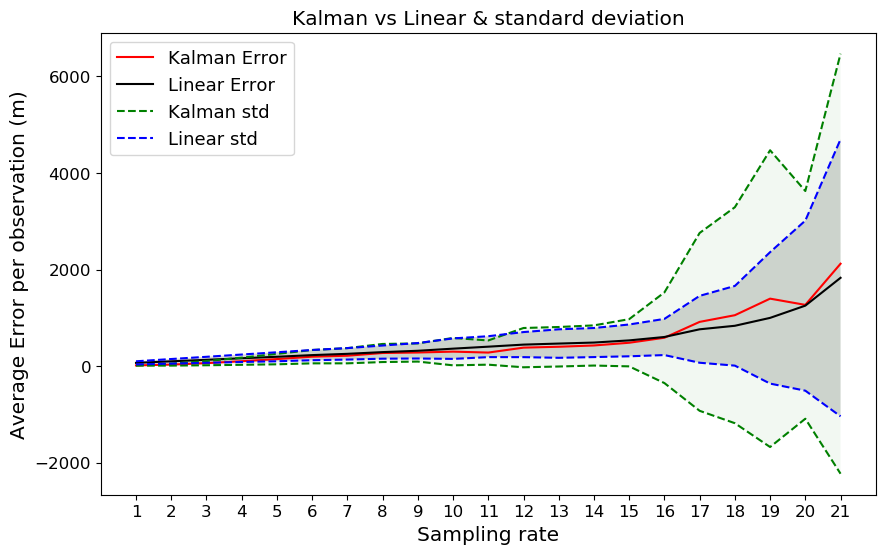

In [179]:
mpl.rcParams['figure.figsize'] = (10,6)
plt.plot(my_sequence,Kalman_errors,"r-")
plt.plot(my_sequence,Linear_errors,"k-")


plt.plot(my_sequence,Kalman_errors_UP,"g--")



plt.plot(my_sequence,Linear_errors_UP,"b--")

plt.plot(my_sequence,Kalman_errors_DOWN,"g--")


plt.plot(my_sequence,Linear_errors_DOWN,"b--")


plt.fill_between(my_sequence,Linear_errors_UP,Linear_errors_DOWN, facecolor = 'grey',alpha = 0.3)
plt.fill_between(my_sequence,Kalman_errors_UP,Kalman_errors_DOWN, facecolor = 'g',alpha = 0.05)





plt.xlabel("Sampling rate", fontsize = 14.5)
plt.ylabel('Average Error per observation (m)', fontsize = 14.5)
plt.title('Kalman vs Linear & standard deviation', fontsize = 14.5)

legend_data = ['Kalman Error','Linear Error', 'Kalman std', "Linear std"]
plt.legend(legend_data, loc = 'best', fontsize = 13)

plt.xticks(np.arange(1, 22, step=1), fontsize = 12)
plt.yticks(fontsize = 12)

#ax.set_xlabel('time [s]', fontsize='large', fontweight='bold')

plt.show()